# Import libraries

In [1]:
# check if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/opt/conda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6143668172009519789
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10931221300
locality {
  bus_id: 1
}
incarnation: 13254605444743483428
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, clone_model
from keras.layers import Dense, Activation, Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.engine.topology import Layer
from keras.datasets import cifar10
from keras.utils import np_utils
print(keras.__version__)

import numpy as np
import matplotlib.pyplot as plt

import VBMF

/opt/conda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.1.6


In [2]:
import tensorly as tl
from tensorly.decomposition import partial_tucker 
# tl.set_backend('numpy')

Using numpy backend.


In [3]:
def get_model():
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3]))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) <- comment out

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model

# Step 1

In [4]:
# get cifar dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# pre-process data
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1  
X_test=2*X_test-1


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# set hyper-params
batch_size=100
lr=0.001
Training=True
Compressing=False

datagen = ImageDataGenerator(
    width_shift_range=0.15,    # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,   # randomly shift images vertically (fraction of total height)
    horizontal_flip=True)      # randomly flip images

model=get_model()
weights_path='pretrained_cifar10.h5'
model.load_weights(weights_path)
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

#make sure weights are loaded correctly:
print(model.evaluate(X_test,y_test,verbose=0))

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[0.40994013208597896, 0.8994]


# Step 2

In [7]:
def convTuckerDecomp(W, ranks):
    """ Apply tucker decomposition on 4-way tensor """
    W = tl.tensor(W)
    core, [I, O] = partial_tucker(W, modes=[2,3], ranks=ranks, init='svd')
    core = tl.to_numpy(core).astype(np.float32)
    I = np.reshape(I,[1,1]+list(I.shape)).astype(np.float32)      # reshape I to 1x1xcxR1
    O = np.reshape(O.T,[1,1]+list(O.T.shape)).astype(np.float32)  # reshape O to 1x1xR2x64
    return I, core, O

### Vary R1 and fix R2 = 64

In [8]:
errR1 = np.zeros(64)
W = model.layers[3].get_weights()[0]   # 2nd conv layer
R1_range = np.arange(1,65)
for i,R1 in enumerate(R1_range):
    print("i: "+str(i))
    ranks = [R1, 64]
    I, core, O =  convTuckerDecomp(W, ranks)
    W_recon =  tl.tenalg.multi_mode_dot(core, [I[0,0,:,:], O[0,0,:,:].T], modes=[2,3], transpose=False)
    errR1[i] = np.linalg.norm(W - W_recon)**2   # calc reconstruction error ||W-W'||^2

### Fix R1 = 64 and vary R2

In [11]:
errR2 = np.zeros(64)
W = model.layers[3].get_weights()[0]   # 2nd conv layer
R2_range = np.arange(1,65)
for i,R2 in enumerate(R2_range):
    print("i: "+str(i))
    ranks = [64, R2]
    I, core, O =  convTuckerDecomp(W, ranks)
    W_recon =  tl.tenalg.multi_mode_dot(core, [I[0,0,:,:], O[0,0,:,:].T], modes=[2,3], transpose=False)
    errR2[i] = np.linalg.norm(W - W_recon)**2   # calc reconstruction error ||W-W'||^2
    

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63


## Plot

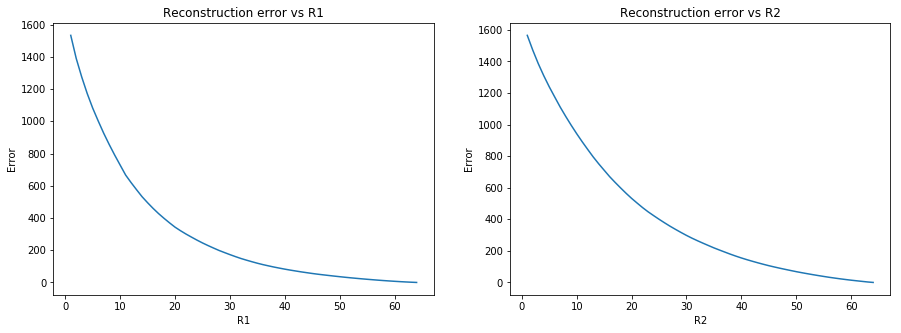

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(R1_range, errR1)
plt.title('Reconstruction error vs R1')
plt.ylabel('Error')
plt.xlabel('R1')

plt.subplot(1,2,2)
plt.plot(R2_range, errR2)
plt.title('Reconstruction error vs R2')
plt.ylabel('Error')
plt.xlabel('R2')

plt.show()

In [13]:
np.save('step2',[errR1,errR2])

In [180]:
[errR1,errR2] = np.load('step2.npy')

# Step 3 and 4

In [8]:
# https://jacobgil.github.io/deeplearning/tensor-decompositions-deep-learning
def decomposeModel(model, x):
    """ Decompose conv layers in model using Tucker Decomposition """
    
    batch_norm_alpha = 0.9
    batch_norm_eps = 1e-4

    model2 = Sequential()

    for idx,l in enumerate(model.layers):
        config = l.get_config()                        # get layer info
                
        if type(l) == Conv2D:
            if idx == 0:                                 # specify input_shape only for first layer
                model2.add(Conv2D(filters=config['filters'], kernel_size=3, strides=(1, 1), padding='valid', input_shape=[32,32,3]))
            else: 
                W,b = l.get_weights()  
                ranks = [int(x*W.shape[2]), int(x*W.shape[3])]
                I, core, O =  convTuckerDecomp(W, ranks)

                # add pointwise conv layer for I
                model2.add(Conv2D(filters=ranks[0], kernel_size=1, strides=1, padding='same'))
                model2.layers[-1].set_weights([I, np.zeros(ranks[0])])
                
                # add regular conv layer for core
                model2.add(Conv2D(filters=ranks[1], kernel_size=config['kernel_size'], strides=config['strides'], 
                                  padding='valid', activation=config['activation']))
                model2.layers[-1].set_weights([core, np.zeros(ranks[1])])
                
                # add pointwise conv laeyr for O. pointwise conv
                model2.add(Conv2D(filters=config['filters'], kernel_size=1, strides=1, padding='same'))
                model2.layers[-1].set_weights([O, b])
                
                continue
                
        elif type(l) == Dense:
            model2.add(Dense(config['units']))
        elif type(l) == BatchNormalization:
            model2.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
        elif type(l) == Activation:
            model2.add(Activation(config['activation']))
        elif type(l) == Flatten:
            model2.add(Flatten())
        elif type(l) == MaxPooling2D:
            model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

        model2.layers[-1].set_weights(l.get_weights())  # keep same weights as model

    return model2

In [ ]:
xRange = np.arange(1,9)/8.0
accNoTrain = np.zeros(len(xRange))
accTrain = np.zeros(len(xRange))
complexity = np.zeros(len(xRange))
for i,x in enumerate(xRange):
    print('x = {}'.format(x))
    model_decomp = decomposeModel(model, x)
    complexity[i] = model_decomp.count_params()
    model_decomp.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    accNoTrain[i] = model_decomp.evaluate(X_test,y_test,verbose=0)[1]  # evaluate on test set w/o training
    model_decomp.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                               steps_per_epoch = X_train.shape[0]/batch_size, 
                               epochs = 10)
    accTrain[i] = model_decomp.evaluate(X_test,y_test,verbose=0)[1]   # eval on test set after training, saving accuracy


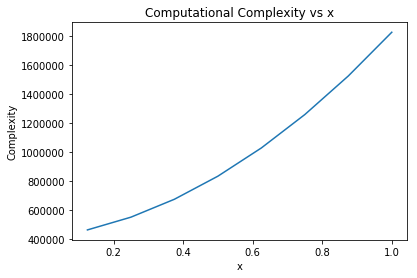

In [17]:
plt.plot(xRange, complexity)
plt.title('Computational Complexity vs x')
plt.ylabel('Complexity')
plt.xlabel('x')
plt.show()

In [21]:
np.save('step3-4',[accNoTrain, accTrain])

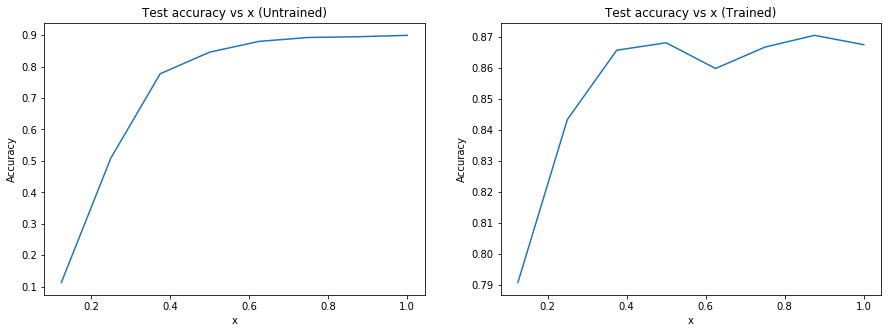

[0.1134 0.5086 0.7772 0.8459 0.8802 0.8927 0.895  0.8994] [0.7908 0.8434 0.8658 0.8682 0.8599 0.8668 0.8706 0.8676]


In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(xRange, accNoTrain)
plt.title('Test accuracy vs x (Untrained)')
plt.ylabel('Accuracy')
plt.xlabel('x')

plt.subplot(1,2,2)
plt.plot(xRange, accTrain)
plt.title('Test accuracy vs x (Trained)')
plt.ylabel('Accuracy')
plt.xlabel('x')

plt.show()

print(accNoTrain, accTrain)

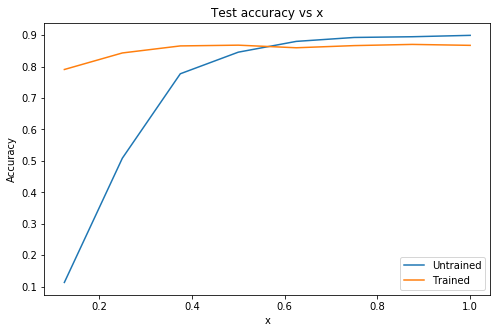

array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [31]:
plt.figure(figsize=(8,5))
# plt.subplot(1,2,1)
plt.plot(xRange, accNoTrain)
plt.title('Test accuracy vs x')
plt.ylabel('Accuracy')
plt.xlabel('x')

# plt.subplot(1,2,2)
plt.plot(xRange, accTrain)
# plt.title('Test accuracy vs x (Trained)')
plt.ylabel('Accuracy')
plt.xlabel('x')
plt.legend(['Untrained','Trained'])

plt.show()
xRange
# print(accNoTrain, accTrain)

# Step 5

In [22]:
def getRanks(layer):
    """ Use VBMF to get R1 and R2 ranks """
    W,b = layer.get_weights()
    unfold_0 = tl.base.unfold(W, 2) 
    unfold_1 = tl.base.unfold(W, 3)
    _, S_0, _, _ = VBMF.EVBMF(unfold_0)   # use to estimate cacb
    _, S_1, _, _ = VBMF.EVBMF(unfold_1)
#     _, S_0, _, _ = VBMF.VBMF(unfold_0, cacb=1)
#     _, S_1, _, _ = VBMF.VBMF(unfold_1, cacb=1)
    ranks = [S_0.shape[0], S_1.shape[0]]
    print("Ranks: ",ranks)
    return ranks

def decomposeModelVBMF(model):
    """ Decompose conv layers in model using Tucker Decomposition """
    
    batch_norm_alpha = 0.9
    batch_norm_eps = 1e-4

    model2 = Sequential()

    for idx,l in enumerate(model.layers):
        config = l.get_config()                        # get layer info
                
        if type(l) == Conv2D:
            if idx == 0:                                 # specify input_shape only for first layer
                model2.add(Conv2D(filters=config['filters'], kernel_size=3, strides=(1, 1), padding='valid', input_shape=[32,32,3]))
            else: 
                W,b = l.get_weights()
                ranks = getRanks(l)
                I, core, O =  convTuckerDecomp(W, ranks)

                # add pointwise conv layer for I
                model2.add(Conv2D(filters=ranks[0], kernel_size=1, strides=1, padding='same'))
                model2.layers[-1].set_weights([I, np.zeros(ranks[0])])
                
                # add regular conv layer for core
                model2.add(Conv2D(filters=ranks[1], kernel_size=config['kernel_size'], strides=config['strides'], 
                                  padding='valid', activation=config['activation']))
                model2.layers[-1].set_weights([core, np.zeros(ranks[1])])
                
                # add pointwise conv laeyr for O. pointwise conv
                model2.add(Conv2D(filters=config['filters'], kernel_size=1, strides=1, padding='same'))
                model2.layers[-1].set_weights([O, b])
                
                continue
                
        elif type(l) == Dense:
            model2.add(Dense(config['units']))
        elif type(l) == BatchNormalization:
            model2.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
        elif type(l) == Activation:
            model2.add(Activation(config['activation']))
        elif type(l) == Flatten:
            model2.add(Flatten())
        elif type(l) == MaxPooling2D:
            model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

        model2.layers[-1].set_weights(l.get_weights())  # keep same weights as model

    return model2

In [23]:
model_decomp_VBMF = decomposeModelVBMF(model)
model_decomp_VBMF.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
hist = model_decomp_VBMF.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                                       steps_per_epoch = X_train.shape[0]/batch_size, 
                                       validation_data = (X_test, y_test),
                                       validation_steps = X_test.shape[0]/batch_size,
                                       epochs = 10)

Ranks:  [31, 23]
Ranks:  [27, 30]
Ranks:  [20, 14]
Ranks:  [35, 38]
Ranks:  [56, 66]
Epoch 1/10
500/500 [==============================] - 24s 48ms/step - loss: 1.0076 - acc: 0.6655 - val_loss: 0.7332 - val_acc: 0.7467
Epoch 2/10
500/500 [==============================] - 19s 38ms/step - loss: 0.7049 - acc: 0.7566 - val_loss: 0.6224 - val_acc: 0.7799
Epoch 3/10
500/500 [==============================] - 20s 39ms/step - loss: 0.6339 - acc: 0.7812 - val_loss: 0.6215 - val_acc: 0.7910
Epoch 4/10
500/500 [==============================] - 20s 39ms/step - loss: 0.5852 - acc: 0.7966 - val_loss: 0.5962 - val_acc: 0.7940
Epoch 5/10
500/500 [==============================] - 20s 40ms/step - loss: 0.5609 - acc: 0.8068 - val_loss: 0.6233 - val_acc: 0.7896
Epoch 6/10
500/500 [==============================] - 19s 38ms/step - loss: 0.5456 - acc: 0.8128 - val_loss: 0.5463 - val_acc: 0.8128
Epoch 7/10
500/500 [==============================] - 19s 38ms/step - loss: 0.5223 - acc: 0.8195 - val_loss: 0.

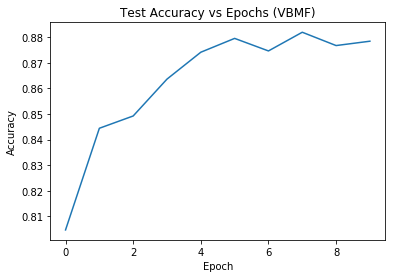

In [29]:
plt.plot(hist.history['val_acc'])
plt.title('Test Accuracy vs Epochs (VBMF)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [26]:
import pickle
with open('step5_v3.pkl', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)
# with open('step5_v2.pkl', 'rb') as f:
#     data = pickle.load(f)
# data